<center><img src="logo_skmob.png" width=450 align="left" /></center>

# Flow models

- Repo: [http://bit.ly/skmob_repo](http://bit.ly/skmob_repo)
- Docs: [http://bit.ly/skmob_doc](http://bit.ly/skmob_doc)
- Paper: [http://bit.ly/skmob_paper](http://bit.ly/skmob_paper)

# Outline

#### Goal: Train a Gravity model in San Francisco and use it to predict the flows in Denver

1. Download checkin data and create a `TrajDataFrame`
1. Create square tessellations for the two cities
1. Compute the relevance (total number of visits) of each tile
1. Create `FlowDataFrame`s for the two cities aggregating the trips in the `TrajDataFrame` that are inside the two regions

4. Compute the total number of trips from each tile (we want to predict the destinations of these trips)
1. Fit a singly-constrained Gravity Model using the trips in San Francisco
1. Use the fitted model to predict the flows in Denver
1. Qualitative evaluation: visualise the performance of the model against a baseline random model
1. Quantitative evaluation: compute various performance metrics

### Import libraries we need

In [26]:
import skmob
from skmob.utils import utils, constants
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt

### Load tessellation and flow data

 - county-to-county flows in New York State 

 - data from the US Census (<a href="https://www.census.gov/topics/employment/commuting/data/tables.html">link1</a>, <a href="https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2011.html">link2</a>)

In [30]:
# load a spatial tessellation
tessellation = gpd.GeoDataFrame.from_file("data/NY_counties_2011.geojson")
# create a FlowDataFrame
fdf = skmob.FlowDataFrame.from_file("data/NY_commuting_flows_2011.csv",
                                    tessellation=tessellation, 
                                    tile_id='tile_id', sep=",")
fdf.head()

,flow,origin,destination
0,121606,36001,36001
1,5,36001,36005
2,29,36001,36007
3,11,36001,36017
4,30,36001,36019


Plot on a map the commute with flows higher than 1000

In [31]:
fdf.plot_flows(min_flow=1000, tiles='cartodbpositron')#.save('/Users/fs13378/Desktop/m.html')

Compute total number of commuters from each origin

In [33]:
# total outflows excluding self loops
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
tessellation[constants.TOT_OUTFLOW] = tot_outflows
tessellation.head()

,tile_id,population,geometry,tot_outflow
0,36019,81716,"POLYGON ((-74.006668 44.886017, -74.027389 44....",29981
1,36101,99145,"POLYGON ((-77.099754 42.274215, -77.0996569999...",5319
2,36107,50872,"POLYGON ((-76.25014899999999 42.296676, -76.24...",295916
3,36059,1346176,"POLYGON ((-73.707662 40.727831, -73.700272 40....",8665
4,36011,79693,"POLYGON ((-76.279067 42.785866, -76.2753479999...",8871


# Gravity model
class `Gravity` has two public methods:

- `fit` calibrates the model's parameters
- `generate` generates flows

In [35]:
from skmob.models import Gravity

### Instantiate a *singly-constrained* Gravity model

In [36]:
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


### Generate flows

In [41]:
np.random.seed(0)
sc_fdf = gravity_singly.generate(tessellation, 
            tile_id_column='tile_id', tot_outflows_column='tot_outflow', 
            relevance_column= 'population', out_format='flows')
sc_fdf.head(3)

100%|██████████| 62/62 [00:00<00:00, 3857.17it/s]


,origin,destination,flow
0,36019,36101,101
1,36019,36107,66
2,36019,36059,1041


Plot on a map the generated flows

In [42]:
sc_fdf.plot_flows(min_flow=1000, tiles='cartodbpositron')#.save('/Users/fs13378/Desktop/m.html')

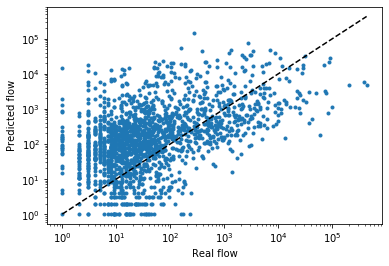

In [54]:
xy = fdf.merge(sc_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
plt.plot(xy[:,0], xy[:,1], '.')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k');
plt.xlabel('Real flow');plt.ylabel('Predicted flow')
plt.loglog();plt.show()

### Fit the gravity model's parameters

In [55]:
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [56]:
gravity_singly_fitted.fit(fdf, relevance_column='population')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-1.9947152031914186], origin_exp=1.0, destination_exp=0.6471759552223144, gravity_type="singly constrained")


#### Generate flows using the fitted model

In [60]:
np.random.seed(0)
sc_fdf_fitted = gravity_singly_fitted.generate(tessellation, 
                                   tile_id_column='tile_id', 
                                   tot_outflows_column='tot_outflow', 
                                   relevance_column= 'population',
                                   out_format='flows')
sc_fdf_fitted.head(3)

100%|██████████| 62/62 [00:00<00:00, 4063.55it/s]


,origin,destination,flow
0,36019,36101,102
1,36019,36107,66
2,36019,36059,1044


In [61]:
sc_fdf_fitted.plot_flows(min_flow=1000, tiles='cartodbpositron')

# Radiation model
- it is is parameter-free 
- has one method: `generate`

In [62]:
from skmob.models import Radiation

In [63]:
radiation = Radiation()

In [65]:
np.random.seed(0)
# flows_avg = radiation.generate(st, out_format='flows_average')
rad_flows = radiation.generate(tessellation,  
                    tile_id_column='tile_id', 
                    tot_outflows_column='tot_outflow', 
                    relevance_column='population', 
                    out_format='flows_sample')
rad_flows.head()

100%|██████████| 62/62 [00:00<00:00, 766.78it/s]


,origin,destination,flow
0,36019,36033,11648
1,36019,36031,4232
2,36019,36089,5598
3,36019,36113,1596
4,36019,36041,117


In [66]:
rad_flows.plot_flows(min_flow=1000, tiles='cartodbpositron')

#### Compare real flows against flows generated by the models

In [69]:
xy_rad = fdf.merge(rad_flows, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
xy_fitted = fdf.merge(sc_fdf_fitted, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

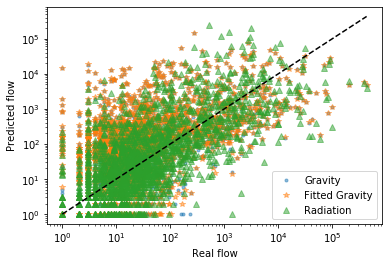

In [71]:
plt.plot(xy[:,0], xy[:,1], '.', alpha=0.5, label='Gravity')
plt.plot(xy_fitted[:,0], xy_fitted[:,1], '*', alpha=0.5, label='Fitted Gravity')
plt.plot(xy_rad[:,0], xy_rad[:,1], '^', alpha=0.5, label='Radiation')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Real flow');plt.ylabel('Predicted flow')
plt.legend(loc='lower right');plt.loglog();plt.show()